## Creative Content Assisted by Generative AI using Titan Image Generator: Inpainting variation

In this notebook, we demonstrate another approach to modify images called inpainting fill. Inpainting fill is the process of replacing a portion of an image with synthesized content based on a textual prompt. We will accomplish this using Titan Image Generator from Amazon Bedrock.


### Setup

Add the import statements 

In [3]:
import os
import boto3
import json
import base64
from io import BytesIO
from PIL import Image

import io
import requests
from random import randint


### Helper function to prepare the request payload for submission to Bedrock

In [4]:
#get the stringified request body for the InvokeModel API call
def get_titan_image_variation_request_body(prompt, image_bytes = None):
        
    body = { #create the JSON payload to pass to the InvokeModel API
        "taskType": "IMAGE_VARIATION",
        "imageVariationParams": {
            "images": [
                image_bytes
            ],  # The image to vary. This array must contain only one element.
            "text": prompt,  # A description of the original image
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of variations to generate
            "quality": "premium",  # Allowed values are "standard" or "premium"
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": randint(0, 100000),  # Use a random seed
        },
    }
    
    return json.dumps(body)

### Helper functions to call Bedrock and extract image from the response


In [5]:
#get a BytesIO object from the Titan Image Generator response
def get_titan_response_image(response):
    
    response = json.loads(response.get('body').read())
    
    images = response.get('images')
    
    image_data = base64.b64decode(images[0])

    return BytesIO(image_data)


#generate an image using Amazon Titan Image Generator
def get_image_from_model(prompt, image_bytes):
    session = boto3.Session(
        profile_name=os.environ.get("BWB_PROFILE_NAME")
    ) #sets the profile name to use for AWS credentials
    
    bedrock = session.client(
        service_name='bedrock-runtime', #creates a Bedrock client
        region_name=os.environ.get("BWB_REGION_NAME"),
        endpoint_url=os.environ.get("BWB_ENDPOINT_URL")
    ) 
    
    body = get_titan_image_variation_request_body(prompt, image_bytes)

    response = bedrock.invoke_model(body=body, modelId="amazon.titan-image-generator-v1", contentType="application/json", accept="application/json")
    
    output = get_titan_response_image(response)
        
    return output

### Pass the image to the helper functions with the textual prompt 

Original Image


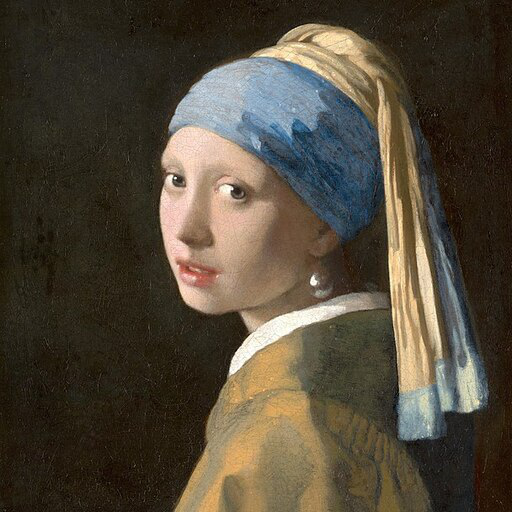

Variant Image


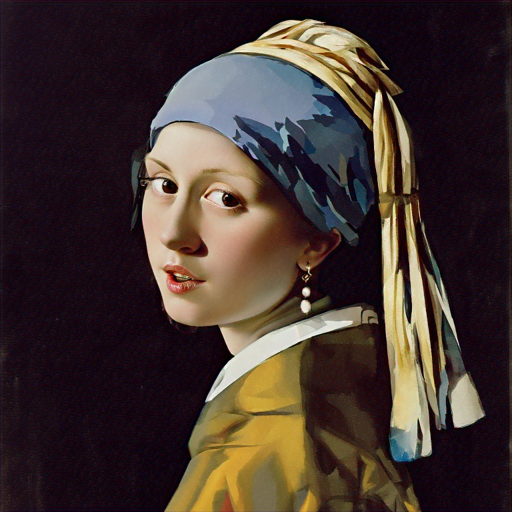

In [8]:

response = requests.get('https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png')
original_image = Image.open(BytesIO(response.content))

print("Original Image")
display(original_image)


input_image = base64.b64encode(response.content).decode('utf8')


image_bytes = get_image_from_model("modern woman", input_image)


print("Variant Image")
image = Image.open(image_bytes)
display(image)